# Mode Injection
- Describe how to use the eigenmode solver to solve for guided modes.
- Describe how to setup mode sources to selectively excite the target mode along a specific propagating direction.
- As a comparison, we also illustrate the field profile when excited by a dipole source.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
from tidy3d import web

In [2]:
# Unit length is micron.
wg_height = 0.25
wg_width = 0.5

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction 
sim_length = 20 #um

# space between waveguide and PML
spacing = 1.5 #um

# Simulation domain size and total run time
sim_size = [sim_length, wg_width + spacing * 2, wg_height + spacing * 2]
run_time = 20/fwidth

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)

# monitor and modal plane size
sz_plane = 2 #um

# Modal source position (x coordinate)
src_pos = -sim_size[0]/2 + spacing

In [3]:
# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=si_eps, name='silicon')
mat_sub = td.Medium(permittivity=sio_eps, name='silica')

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2*sim_size[2]-wg_height],
    ),
    medium=mat_sub,
    name='substrate',
)

# Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, wg_width, wg_height],
    ),
    medium=mat_wg,
    name='waveguide',
)

In [4]:
mnt_list = []

# xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FieldMonitor(
    center=[0, 0, 0],
    size=[np.inf, np.inf, 0],
    freqs=[freq0],
    name='field')
mnt_list.append(freq_mnt)

# A series of flux monitors
offset_from_source = 0.05 # the space between the 1st monitor and the source

pos_start = src_pos + offset_from_source # define the positions of the monitor
pos_end = sim_size[0]/2-spacing
num = 100
pos_list = np.linspace(pos_start,pos_end,num)

for i in range(num):
    flux_mnt = td.FluxMonitor(
        center= [pos_list[i], 0, 0],
        size=[0, sz_plane, sz_plane],
        freqs=[freq0],
        name='flux'+str(i),
    )

    mnt_list.append(flux_mnt)

In [5]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, waveguide],
    sources=[],
    monitors=mnt_list,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()))

In [6]:
# position and size of source plane
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, sz_plane, sz_plane])

# number of modes to compute
num_modes = 2

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

23:32:09 +07 WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

Effective index of computed modes:  [[2.5667737 2.008354 ]]


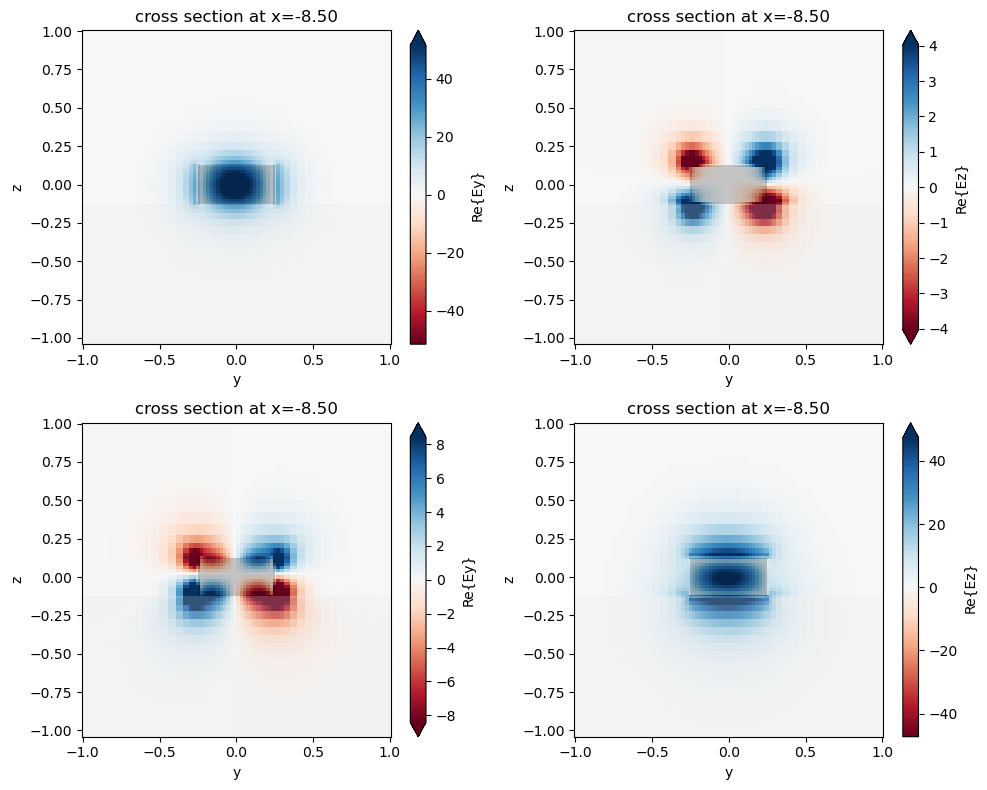

In [7]:
fig, axs = plt.subplots(num_modes, 2, figsize=(10, 8), tight_layout=True)
for mode_ind in range(num_modes):
    ms.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    ms.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
plt.show()

In [8]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_source = ms.to_source(mode_index=0, direction="+", source_time=source_time)
sim = sim.copy(update={'sources':[mode_source]})

In [9]:
point_source = td.PointDipole(
    center=(src_pos, wg_width/4, wg_height/4),
    source_time=source_time,
    polarization='Ey',
    name='point source',
)
sim_point = sim.copy(update={'sources':[point_source]})

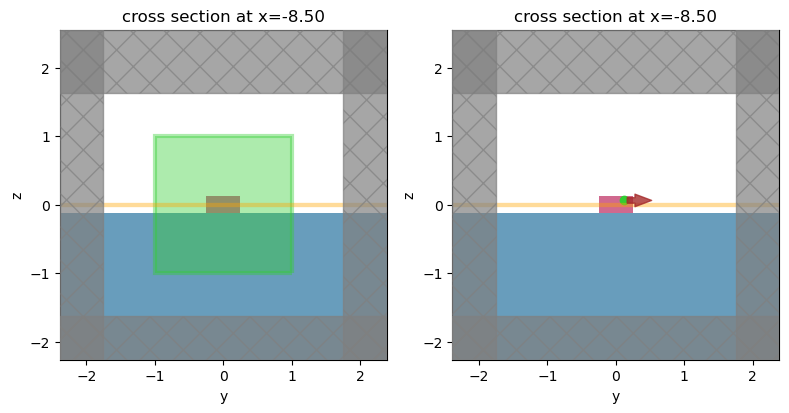

In [10]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=src_pos, ax=ax[0]);
sim_point.plot(x=src_pos, ax=ax[1]);
plt.show()

In [11]:
sim_data = web.run(sim, task_name='lecture04_mode_source', path=f'data/data_mode.hdf5')
sim_point_data = web.run(sim_point, task_name='lecture04_point_source', path=f'data/data_point.hdf5')

23:33:07 +07 Created task 'lecture04_mode_source' with task_id                  
             'fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=780884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=177577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\taskId]8;;\]8;id=780884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\=]8;;\]8;id=482710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\fdve]8;;\]8;id=780884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\-75f86824-fb8]8;;\
             ]8;id=780884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\e-46b9-b7f6-6d4f9294b54d']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:33:11 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:33:16 +07 status = preprocess

23:33:20 +07 Maximum FlexCredit cost: 0.072. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

23:33:27 +07 early shutoff detected at 36%, exiting.

23:33:28 +07 status = postprocess

23:33:30 +07 status = success

             View simulation result at                                          
             ]8;id=666254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=334321;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\taskId]8;;\]8;id=666254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\=]8;;\]8;id=499225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\fdve]8;;\]8;id=666254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\-75f86824-fb8]8;;\
             ]8;id=666254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-75f86824-fb8e-46b9-b7f6-6d4f9294b54d\e-46b9-b7f6-6d4f9294b54d']8;;\.

23:33:41 +07 loading simulation from data/data_mode.hdf5

             Created task 'lecture04_point_source' with task_id                 
             'fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=436422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=191842;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\taskId]8;;\]8;id=436422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\=]8;;\]8;id=414868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\fdve]8;;\]8;id=436422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\-ce04aac7-90e]8;;\
             ]8;id=436422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\7-4637-9ac5-267fc891fd87']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:33:45 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:33:49 +07 status = preprocess

23:33:52 +07 Maximum FlexCredit cost: 0.069. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

23:33:59 +07 early shutoff detected at 40%, exiting.

             status = postprocess

23:34:01 +07 status = success

23:34:02 +07 View simulation result at                                          
             ]8;id=118360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=220720;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\taskId]8;;\]8;id=118360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\=]8;;\]8;id=294170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\fdve]8;;\]8;id=118360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\-ce04aac7-90e]8;;\
             ]8;id=118360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce04aac7-90e7-4637-9ac5-267fc891fd87\7-4637-9ac5-267fc891fd87']8;;\.

23:34:09 +07 loading simulation from data/data_point.hdf5

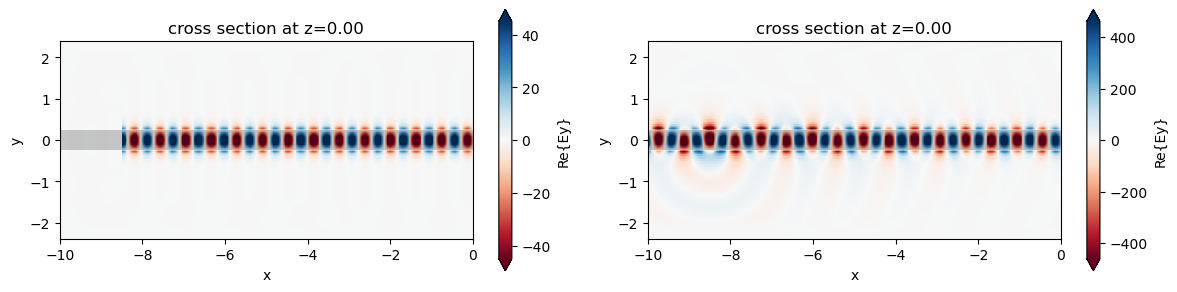

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12, 3), tight_layout=True)

sim_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[0])
sim_point_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[1])
ax[0].set_xlim([-10,0])
ax[1].set_xlim([-10,0])
plt.show()

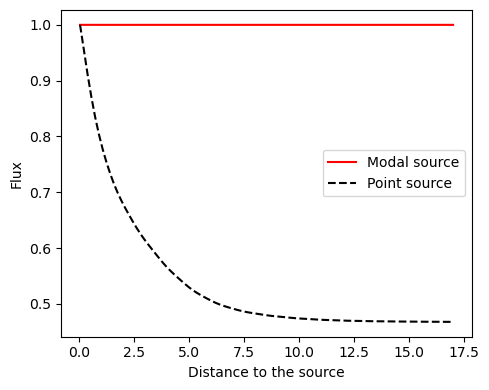

In [13]:
flux_list = np.zeros_like(pos_list)
flux_point_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    flux_point_list[i] = sim_point_data['flux'+str(i)].flux

# normalize the dipole one
flux_point_list /= flux_point_list[0]

fig, ax = plt.subplots(1,figsize=(5, 4), tight_layout=True)
ax.plot(pos_list - src_pos, flux_list, '-r',label='Modal source')
ax.plot(pos_list - src_pos, flux_point_list, '--k', label='Point source')
ax.set_xlabel('Distance to the source')
ax.set_ylabel('Flux')
ax.legend()
plt.show()